In [3]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

In [4]:
## Nome dos paths onse estão salvos e vamos salvar os dados processados
PATH_FAIXA_ETARIAS = '../dados/faixa_etaria/' # Nome do path dos arquivos salvos
PATH_DADOS_PROCESSADOS = '../dados/e_sus_processados/' # Nome do path a salvar os arquivos
PATH_MUNICIPIOS = '../dados/processados/'
PATH_ESTADO = '../dados/municipios/'
PATH_FIGURAS = '../figure/'

FILES_ESTADOS = os.listdir(PATH_DADOS_PROCESSADOS)
FILENAME_FAIXA_ETARIAS = 'faixa_etaria_processada.csv'
FILENAME_MUNICIPIOS = 'municipios_processada.csv'
FILENAME_ESTADO = 'estados_processada.csv'

dfMunicipios_d = pd.read_csv(PATH_MUNICIPIOS + FILENAME_MUNICIPIOS, encoding='utf-8', delimiter=';')
dfFE = pd.read_csv(PATH_FAIXA_ETARIAS + FILENAME_FAIXA_ETARIAS, encoding='utf-8', delimiter=';')
dfEstado_d = pd.read_csv(PATH_ESTADO + FILENAME_ESTADO, encoding='utf-8', delimiter=';')

cols = ['dataNotificacao', 'sexo', 'idade', 'estado_normalizado', 'municipio_normalizado', 'extractDate', 'idadeTrunc']

dflist = []

for file in FILES_ESTADOS:
    dfLoad = pd.read_csv(PATH_DADOS_PROCESSADOS + file, encoding='utf-8', delimiter=';', compression='zip')
    dfLoad = dfLoad[[c for c in dfLoad.columns if c in cols]]
    dflist.append(dfLoad.copy())
    
    print(f'Lido csv {file}')

dfProc = pd.concat(dflist).dropna(how='any',axis=0)

FileNotFoundError: [Errno 2] No such file or directory: '../dados/e_sus_processados/'

In [ ]:
dfProc.count()

A base com a populacao dividida em faixa etária é tratada para que numa mesma coluna fiquem o população total, segmentada pelo estado e pela faixa etária a qual pertencem

In [ ]:
###################
# dfEstado
###################

cols_sel = ['uf', 
            'estado_normalizado']
dfEstado = dfEstado_d.reset_index()
dfEstado = dfEstado[cols_sel].set_index('uf')
dfEstado

In [ ]:
###################
# df dos Municipios
###################

cols_sel = ['codigo_ibge', 
            'municipioNormalizado', 
            'codigo_uf', 
            'uf', 
            'estado', 
            'densidade_populacional', 
            'area_mun', 
            'populacao_estimada']
dfMunicipios = dfMunicipios_d[cols_sel].set_index('uf')

In [ ]:
###################
# Cruzamento dos municipios com dfEstado para trazer densidade populacional por estado
###################
dfEstado = (dfMunicipios.join(dfEstado, on = ['uf'])
            .rename(columns= {'municipioNormalizado' : 'municipio_normalizado'})
            .reset_index().set_index(['estado_normalizado', 'municipio_normalizado'])
           )

In [ ]:
dfEstadoCopy = dfEstado.copy()
dfEstado

In [5]:
###################
# calcular com a densidade populacional por estado
###################

dfDensEstado = dfEstado[['area_mun', 'populacao_estimada', 'densidade_populacional']]
# dfDensEstado = dfDensEstado.loc[dfDensEstado['densidade_populacional'] > 500]
dfDensEstado

NameError: name 'dfEstado' is not defined

In [ ]:
###################
# Tratamento do df com os casos de Covid
###################

dfIdadeEstado = (dfProc[['extractDate', 'estado_normalizado', 'municipio_normalizado']].copy()
                 .reset_index(drop=True)
                 .set_index('estado_normalizado', 'municipio_normalizado'))

# dfIdadeEstado['dateTruncate'] = pd.to_datetime(dfIdadeEstado['extractDate']).dt.to_period('M') 

### Cruzamento dos dados com informações dos estados

O intuito desse cruzamento e a homogenização dos dados com a informação geográfica e nomeclatura dos estados. 

In [ ]:
################################
# Agrupamento por Idade e Estado
################################
dfGroupIdEst = (dfIdadeEstado
         .groupby(['estado_normalizado', 'municipio_normalizado']).size()
         .reset_index(name='soma_casos_covid')
         .rename(columns={'extractDate': 'soma_casos_covid'})
         .set_index(['estado_normalizado', 'municipio_normalizado'])
        )

################################
# Restringindo valores
################################
dfGroupIdEstCom = dfGroupIdEst.copy()

################################
# normalizando
################################

def normalizar_column(df, dfDenEst):
    fact_norm = 1000
    col_norm = f'norm_x{fact_norm}Hab'
    df = df.merge(dfDenEst, on = ['estado_normalizado', 'municipio_normalizado'])
    df['norm'] = df['soma_casos_covid'].div(df['populacao_estimada'])
    df[col_norm] = df['soma_casos_covid'].div(df['populacao_estimada'])*fact_norm
    df = df.dropna(how='any',axis=0)
    return (df, col_norm)

dfFinalIdEstCom, col_norm = normalizar_column(dfGroupIdEstCom, dfDensEstado)
dfFinalIdEst, col_norm = normalizar_column(dfGroupIdEst, dfDensEstado)

dfFinalIdEst = dfFinalIdEst.loc[dfFinalIdEst['soma_casos_covid'] > 1000]
dfFinalIdEst = dfFinalIdEst.loc[dfFinalIdEst['populacao_estimada'] > 100000]
dfFinalIdEst = dfFinalIdEst.loc[dfFinalIdEst['densidade_populacional'] > 10]


In [ ]:
dfFinalIdEst.columns

In [ ]:
################################
# Plot do df Completo
################################

x_column = 'densidade_populacional'
# y_column = col_norm
y_column = 'norm'
dfFinalIdEstCom.sort_values(x_column).plot(kind = 'scatter', x = x_column, y=y_column, figsize=(10,5))
plt.grid()
plt.savefig(f'{PATH_FIGURAS}densidade_populacional_completo.png', bbox_inches = 'tight', pad_inches = 0)

In [ ]:
################################
# Plot do df com restrições
################################
x_column = 'densidade_populacional'
# y_column = col_norm
y_column = 'norm'
dfFinalIdEst.sort_values(x_column).plot(kind = 'scatter', x = x_column, y=y_column, figsize=(10,5))
plt.grid()

In [ ]:
## Normalizando a densidade com uma distribuição normal
dfFinalIdEst['dens_dist_normal'] = (dfFinalIdEst['densidade_populacional']-dfFinalIdEst['densidade_populacional'].mean())/dfFinalIdEst['densidade_populacional'].std()
dfFinalIdEst['popu_dist_normal'] = (dfFinalIdEst['populacao_estimada']-dfFinalIdEst['populacao_estimada'].mean())/dfFinalIdEst['populacao_estimada'].std()
dfFinalIdEst.count()

In [ ]:
dfFinalIdEstOutlier = dfFinalIdEst[(np.abs(stats.zscore(dfFinalIdEst[['norm']])) < 3).all(axis=1)]
dfFinalIdEstOutlier

In [ ]:
dfKmeans = dfFinalIdEstOutlier[['dens_dist_normal', 'norm']]
  
kmeans = KMeans(n_clusters=3).fit(dfKmeans)
centroids = kmeans.cluster_centers_
print(centroids)

# fig = plt.figure()
# ax = Axes3D(fig)

# ax.scatter(dfKmeans['dens_dist_normal'], dfKmeans['norm'], dfKmeans['popu_dist_normal'], c= kmeans.labels_.astype(float), s=50, alpha=0.5)
# ax.scatter(centroids[:, 0], centroids[:, 1], c='red', s=50)
# ax.set_zlim([0, 10])
plt.figure(figsize=(8,4))
plt.scatter(dfKmeans['dens_dist_normal'], dfKmeans['norm'], c= kmeans.labels_.astype(float), s=50, alpha=0.5)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=50)
plt.ylabel("Casos Normalizados")
plt.xlabel("Densidade populacional Normalizada")
plt.grid()
plt.savefig(f'{PATH_FIGURAS}Kmeans.png', bbox_inches = 'tight', pad_inches = 0)

In [27]:
dfFinalIdEstOutlier = dfFinalIdEstOutlier.reset_index()
dfFinalIdEstOutlier['kmeans_cluster'] = pd.Series(kmeans.labels_.astype(float))
dfFinalIdEstOutlier = dfFinalIdEstOutlier.set_index(['estado_normalizado', 'municipio_normalizado'])
dfFinalIdEstOutlier

soma_casos_covid   area_mun  \
estado_normalizado municipio_normalizado                                   
acre               rio branco                           10982   8834.942   
alagoas            arapiraca                            15234    345.655   
                   maceio                               31211    509.320   
amazonas           itacoatiara                           2429   8891.906   
                   manaus                               60713  11401.092   
...                                                       ...        ...   
sergipe            aracaju                              26139    182.163   
                   lagarto                               2459    968.921   
                   nossa senhora do socorro              2088    155.018   
tocantins          araguaina                            18978   4004.646   
                   palmas                                4826   2227.444   

                                             populacao_estimada  \
estado_normalizado municipio_normalizado                          
acre               rio branco                            413418   
alagoas            arapiraca                             233047   
                   maceio                               1025360   
amazonas           itacoatiara                           102701   
                   manaus                               2219580   
...                                                         ...   
sergipe            aracaju                               664908   
                   lagarto                               105221   
                   nossa senhora do socorro              185706   
tocantins          araguaina                             183381   
                   palmas                                306296   

                                             densidade_populacional      norm  \
estado_normalizado municipio_normalizado                                        
acre               rio branco                             46.793516  0.026564   
alagoas            arapiraca                             674.218513  0.065369   
                   maceio                               2013.194063  0.030439   
amazonas           itacoatiara                            11.549942  0.023651   
                   manaus                                194.681352  0.027353   
...                                                             ...       ...   
sergipe            aracaju                              3650.071639  0.039312   
                   lagarto                               108.596057  0.023370   
                   nossa senhora do socorro             1197.964107  0.011244   
tocantins          araguaina                              45.792063  0.103489   
                   palmas                                137.510079  0.015756   

                                             norm_x1000Hab  dens_dist_normal  \
estado_normalizado municipio_normalizado                                       
acre               rio branco                    26.563914         -0.559007   
alagoas            arapiraca                     65.368788         -0.294290   
                   maceio                        30.439065          0.270638   
amazonas           itacoatiara                   23.651182         -0.573877   
                   manaus                        27.353373         -0.496612   
...                                                    ...               ...   
sergipe            aracaju                       39.312206          0.961254   
                   lagarto                       23.369860         -0.532932   
                   nossa senhora do socorro      11.243579         -0.073316   
tocantins          araguaina                    103.489456         -0.559430   
                   palmas                        15.756001         -0.520733   

                                             popu_dist_normal  kmeans_cluster  
estado_no

### Para o Cluster 0

In [69]:
def plot_corr(df):
    corr = df[['soma_casos_covid', 'area_mun', 'norm', 'populacao_estimada', 'densidade_populacional']].corr()
    sns.heatmap(corr, 
                xticklabels=corr.columns.values, 
                yticklabels=corr.columns.values, 
                cmap = 'RdYlGn_r', 
                annot=True)
    return corr

def plot_regression(df, eixoX, eixoY, name_grafico):
    y = df[eixoY]
    x = df[eixoX]
    a, b, r, p, std_err = stats.linregress(x, y)
    dfResult = df.copy()
    dfResult['y_estimated'] = df[eixoX].apply(lambda x: a * x + b)
    print(f"Coeficiente de correlação : {r**2}")
    
    plt.figure(figsize=(10,5))
    plt.plot(dfResult[eixoX], dfResult['y_estimated'], 'g-')
    plt.scatter(dfResult[eixoX], dfResult[eixoY])
    plt.ylabel(eixoY)
    plt.xlabel(eixoX)
    plt.grid()
    plt.savefig(f'{PATH_FIGURAS}{name_grafico}.png', bbox_inches = 'tight', pad_inches = 0)

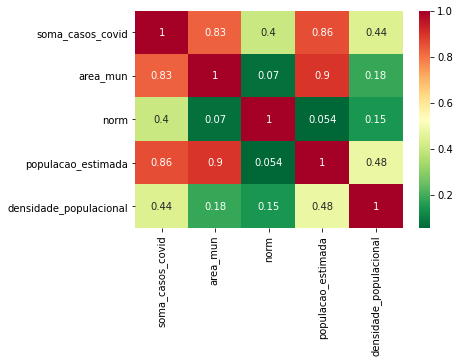

In [38]:
dfCluster0 = dfFinalIdEstOutlier.loc[dfFinalIdEstOutlier['kmeans_cluster'] == 0]
corr0 = plot_corr(dfCluster0)

Coeficiente de correlação : 0.021702067075386473


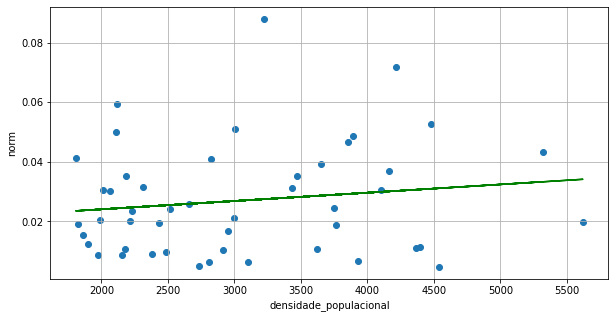

In [70]:
plot_regression(dfCluster0, 'densidade_populacional', 'norm', 'regression_cluster0')

### Para o cluster 1

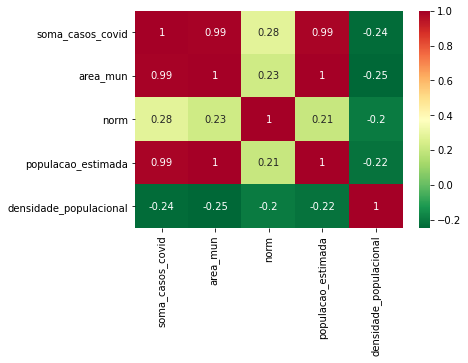

In [39]:
dfCluster1 = dfFinalIdEstOutlier.loc[dfFinalIdEstOutlier['kmeans_cluster'] == 1]
corr1 = plot_corr(dfCluster1)

Coeficiente de correlação : 0.038531904602388437


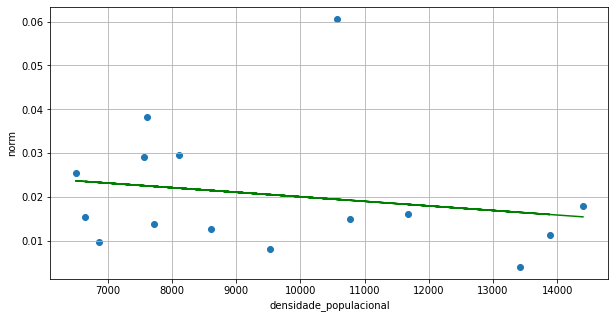

In [71]:
plot_regression(dfCluster1, 'densidade_populacional', 'norm', 'regression_cluster1')

### Para o cluster 2

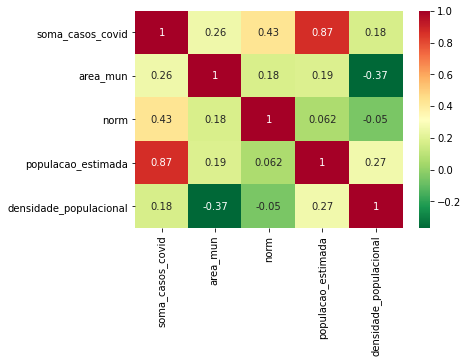

In [40]:
dfCluster2 = dfFinalIdEstOutlier.loc[dfFinalIdEstOutlier['kmeans_cluster'] == 2]
corr2 = plot_corr(dfCluster2)

Coeficiente de correlação : 0.00254542436823241


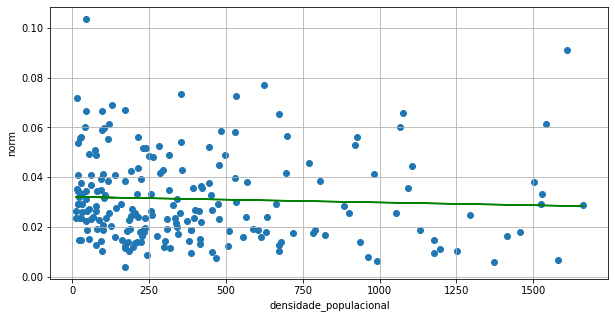

In [72]:
plot_regression(dfCluster2, 'densidade_populacional', 'norm', 'regression_cluster2')

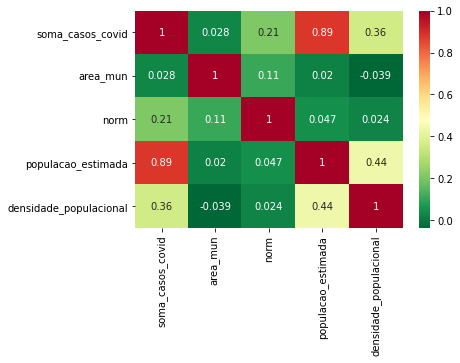

In [41]:
## Correlação Matriz Completa
corrCom = plot_corr(dfFinalIdEstCom)

In [58]:
corrCom['Fonte'] =  'Completo'
corr0['Fonte'] =  'Cluster 0'
corr1['Fonte'] =  'Cluster 1'
corr2['Fonte'] =  'Cluster 2'

dfCorrFinal = pd.concat([corrCom, corr0, corr1, corr2]).reset_index()
dfCorrFinal.loc[dfCorrFinal['index'] == 'soma_casos_covid'].set_index('Fonte').drop('index', axis=1)



# from sklearn.cluster import KMeans

# dfKmeans = dfFinalIdEstOutlier[['dens_dist_normal', 'norm', 'populacao_estimada']]
  
# kmeans = KMeans(n_clusters=3).fit(dfKmeans)
# centroids = kmeans.cluster_centers_
# print(centroids)

# plt.scatter(dfKmeans['dens_dist_normal'], dfKmeans['norm'], c= kmeans.labels_.astype(float), s=50, alpha=0.5)
# plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=50)
# # plt.show()

,soma_casos_covid,area_mun,norm,populacao_estimada,densidade_populacional
Fonte,,,,,
Completo,1.0,0.028150,0.211333,0.886327,0.358990
Cluster 0,1.0,0.828956,0.402471,0.856655,0.444031
Cluster 1,1.0,0.991900,0.284061,0.989240,-0.237091
Cluster 2,1.0,0.257393,0.432073,0.870706,0.176186


In [330]:

# x_column = 'dens_dist_normal'
# # y_column = col_norm
# y_column = 'norm'
# dfFinalIdEstOutlier.sort_values(x_column).plot(kind = 'scatter', x = x_column, y=y_column, figsize=(10,5))
# plt.grid()
# # plt.xlim([-1, 500])
# # plt.ylim([0, 0.1])
# # Casos per capita
# # Análise sobre cidades maiores de 1e5 hab

In [331]:
# dfFinalIdEstOutlier[['soma_casos_covid', 'area_mun', 'norm', 'populacao_estimada', 'densidade_populacional', 'dens_dist_normal']].corr()

In [332]:
# corr = dfFinalIdEstOutlier[['soma_casos_covid', 'area_mun', 'norm', 'populacao_estimada', 'densidade_populacional']].corr()
# sns.heatmap(corr, 
#             xticklabels=corr.columns.values, 
#             yticklabels=corr.columns.values, 
#             cmap = 'RdYlGn_r', 
#             annot=True)

# Correlação ao longo do tempo
# 

In [333]:
# y = dfFinalIdEstOutlier['norm']
# x = dfFinalIdEstOutlier['densidade_populacional']
# a, b, r, p, std_err = stats.linregress(x, y)
# r*r

In [334]:
# dfFinalIdEstOutlier['y_estimated'] = dfFinalIdEstOutlier['densidade_populacional'].apply(lambda x: a * x + b)

# plt.figure()
# plt.plot(dfFinalIdEstOutlier['densidade_populacional'], dfFinalIdEstOutlier['y_estimated'], 'g-')
# plt.scatter(dfFinalIdEstOutlier['densidade_populacional'], dfFinalIdEstOutlier['norm'])
# plt.grid()
# # plt.xlim([0, 100000])
# # plt.ylim([0, 100])
